# Resident Population over time

In [12]:
from nbdev import *
from istatapi import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# set matplotlib themes
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 5]
#fiveThirtyEight palette
colors = ['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b']

The graph we are trying to reproduce is about imports and exports. With `istatapi` we can search through all the available datasets by simply using the following function:

In [13]:
all_available_df = all_available()
all_available_df.query('df_id == "22_289"')

,df_id,version,df_description,df_structure_id
208,22_289,1.5,Resident population on 1st January,DCIS_POPRES1


To retrieve data from a specific dataset, we first need to create an instance of the `DataSet` class. We can use `df_id`, `df_description` or `df_structure_id` from the above DataFrame. This may take a few seconds to load.

In [14]:
# initialize the dataset and get its dimensions
ds = DataSet(dataflow_identifier="22_289")

We now want to see what variables are included in the dataset that we are analysing. With `istatapi` we can easily print its variables ("dimensions" in ISTAT terminology) and their description.

In [15]:
ds.dimensions_info()

,dimension,dimension_ID,description
0,FREQ,CL_FREQ,Frequency
1,ETA,CL_ETA1,Age class
2,ITTER107,CL_ITTER107,Territory
3,SESSO,CL_SEXISTAT1,Gender
4,STACIVX,CL_STATCIV2,Marital status
5,TIPO_INDDEM,CL_TIPO_DATO15,Data type 15


Now, each dimension can have a few possible values. `istatapi` provides a quick method to analyze these values and print their English descriptions. 

In [16]:
dimension = "SESSO" #use "dimension" column from above
ds.get_dimension_values(dimension)

,values_ids,values_description
0,1,males
1,9,total
2,2,females


If we do not filter any of our variables, the data will just include all the possible values in the dataset. This could result in too much data that would slow our code and make it difficult to analyze. Thus, we need to filter our dataset. To do so, we can simply use the `values_ids` that we found using the function `get_dimension_values` in the cell above.

**Note**: Make sure to pass the names of the dimensions in lower case letters as arguments of the `set_filter` function. If you want to filter for multiple values, simply pass them as lists.

In [17]:
freq = "A" #Annual frequency
itter107 = 'IT' #Italy
stacivx = "99" #total marital status
sesso = "9" #total

ds.set_filters(freq = freq, itter107 = itter107, stacivx = stacivx, sesso = sesso)

Having set our filters, we can now finally retrieve the data by simply passing our `DataSet` instance to the function `get_data`. It will return a pandas DataFrame with all the data that we requested. The data will be already sorted by datetime

In [18]:
residents_df = get_data(ds)
residents_df.head()

,DATAFLOW,FREQ,ETA,ITTER107,SESSO,STACIVX,TIPO_INDDEM,TIME_PERIOD,OBS_VALUE,BREAK,CONF_STATUS,OBS_PRE_BREAK,OBS_STATUS,BASE_PER,UNIT_MEAS,UNIT_MULT,METADATA_EN,METADATA_IT
0,IT1:22_289(1.5),A,TOTAL,IT,9,99,JAN,2019-01-01,59816673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,IT1:22_289(1.5),A,Y52,IT,9,99,JAN,2019-01-01,983002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255,IT1:22_289(1.5),A,Y53,IT,9,99,JAN,2019-01-01,980231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,IT1:22_289(1.5),A,Y26,IT,9,99,JAN,2019-01-01,636390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,IT1:22_289(1.5),A,Y54,IT,9,99,JAN,2019-01-01,992363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
residents_df.TIME_PERIOD.unique()

<DatetimeArray>
['2019-01-01 00:00:00', '2020-01-01 00:00:00', '2021-01-01 00:00:00',
 '2022-01-01 00:00:00', '2023-01-01 00:00:00']
Length: 5, dtype: datetime64[ns]

In [20]:
import numpy as np
def tweak_residents_df(residents_df):
    residents_df = residents_df.query('ETA != "TOTAL"').copy()
    
    residents_df = residents_df.rename(columns={"TIME_PERIOD": "year"})
    residents_df['year'] = pd.to_datetime(residents_df['year'], format='%Y')
    residents_df['ETA'] = residents_df['ETA'].astype(str).str.replace('Y', '').str.replace('_GE100', '100').astype(int)
    residents_df['ETA_bin'] = pd.cut(residents_df['ETA'], bins= [0, 25, 45, 65, np.inf], labels=['0-25', '25-45', '45-65', '65+'])
    return (residents_df
            .groupby(['year', 'ETA_bin']).sum().reset_index()
            )

residents_df2 = tweak_residents_df(residents_df)

/var/folders/nv/1j84v2y15czd4v1mcwd58r780000gq/T/ipykernel_6377/2170393130.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'ETA_bin']).sum().reset_index()


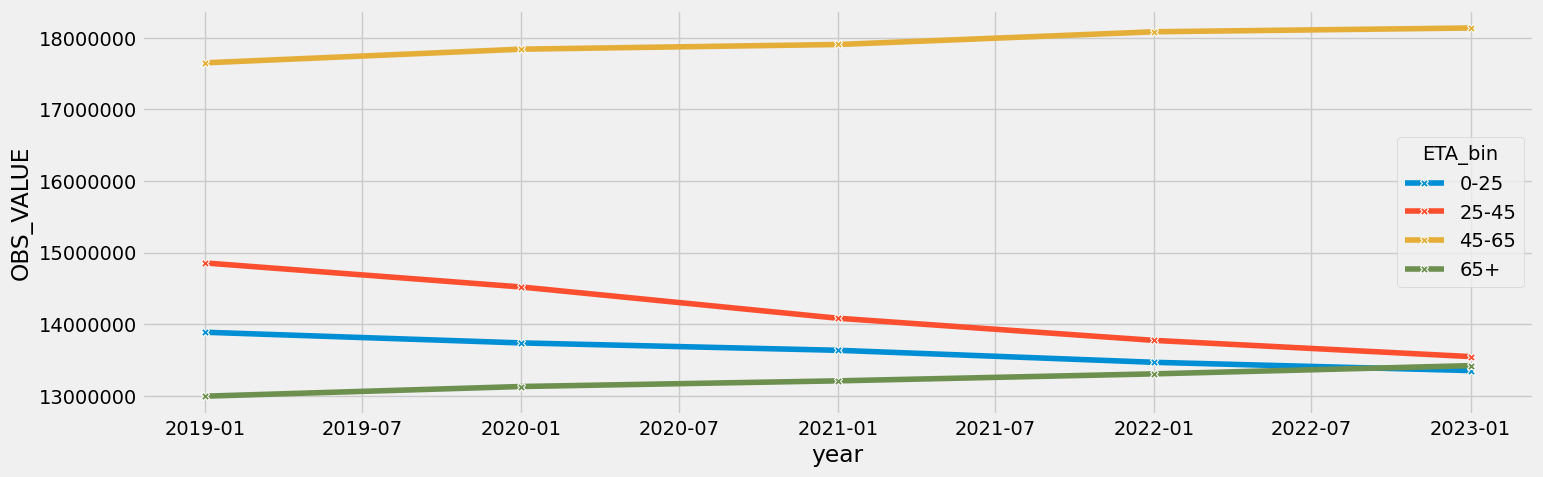

In [21]:
# Plot the data
sns.lineplot(data=residents_df2, x="year", y="OBS_VALUE", hue="ETA_bin", marker = 'X')
plt.rcParams["figure.figsize"] = (15, 4)
plt.ticklabel_format(style='plain', axis='y')

And That's it! With a few lines of code we were able to neatly reproduce the graph!